In [1]:
import ee 
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Autheticate and then initialize the session using your credentials
#ee.Authenticate()
ee.Initialize()

In [126]:
def return_time_series_collection(start_time='2000-01-01',end_time='2018-01-01',
                       data_source='LANDSAT/LC8_L1T_TOA',
                       cloud_cover=5,
                       input_bands=['B4','B5','B6'],
                       roi = [5.727906, 51.993435,
                                 5.588144, 51.944356]):
    '''
    Time: yyyy-mm-dd
    roi: Region-of-interest
    
    '''
    
    ## Define your image collection 
    collection = ee.ImageCollection(data_source)
    
    ## Define time range and filter the data
    collection_time = collection.filterDate(start_time, end_time) #YYYY-MM-DD
    
    x0,y0,x1,y1 = roi
    
    ROI = ee.Geometry.Rectangle([x0,y0,
                                 x1,y1])
    
    
    
    #collection_time = collection_time.filter(ee.Filter.eq('WRS_PATH', 198))
    #collection_time = collection_time.filter(ee.Filter.eq('WRS_ROW', 24))
    
    # Filter by a specific region
    filterRegion = collection_time.filterBounds(ROI)
    
    ## Select imagery with less then 5% of image covered by clouds
    clouds = filterRegion.filter(ee.Filter.lt('CLOUD_COVER', cloud_cover))
    
    ## Select bands
    bands = clouds.select(input_bands)
    
    eeCollection = bands
    
    collectionList = bands.toList(bands.size()) # Converts the image collection to a list accessible via index
    collectionSize = collectionList.size().getInfo()
    
    # Get the information about the dates of this collection 'SENSING_TIME'
    #collectionDates = [ee.Image(collectionList.get(indx)).getInfo()['properties']['DATE_ACQUIRED'] for indx in range(collectionSize)]
    
    # For the new data
    collectionDates = [ee.Image(collectionList.get(indx)).getInfo()['properties']['SENSING_TIME'] for indx in range(collectionSize)]
    
    
    return collectionSize,collectionList,collectionDates,eeCollection


def normalize(data):
    '''
    Normalize the data from 0->1
    '''
    
    norm = (data-data.min())/(data.max()-data.min())
    
    return norm

def convert_image_to_numpy(image,
                           roi=[5.727906, 51.993435,
                                5.588144, 51.944356],
                           input_bands=['B4','B5','B6'],
                          normalized=True):
    '''
    Converts a single image in the collection List to a numpy array
    
    
    This only works for smaller satellite image regions
    
    '''
    
    
    #image = ee.Image(collectionList.get(indx))
    ROI = ee.Geometry.Rectangle(roi)
    
    band_arrs = image.sampleRectangle(region=ROI,defaultValue=0)
    #band_arrs = image.stratifiedSample(region=ROI)
    
    img_arrays = [ np.array(band_arrs.get(band).getInfo()) for band in input_bands]
    
    # Rescale the arrays
    if(normalized==True):
        img_arrays = [normalize(img_array) for img_array in img_arrays]
    
    img_arrays = [np.expand_dims(img_array, 2) for img_array in img_arrays]
    rgb_img = np.concatenate(img_arrays, 2)
    
    
    return rgb_img

def convert_collection_to_numpy(roi,collectionSize,collectionList,collectionDates):
    '''
    Converts all of the images in a collection to numpy matrices,
    and filters 
    '''
    ROI = ee.Geometry.Rectangle(roi)
    
    for k in range(collectionSize):
        image = ee.Image(collectionList.get(k))
        
        try:
            band_arrs = image.sampleRectangle(region=ROI)
        except:
            pass
    
    
    return newCollectionSize,newCollectionList,newCollectionDates


def train_Kmeans_classifier(img,K,roi):
    '''
    This simple function trains a K-means classifier on an image
    '''
    
    input = ee.Image(img)
    
    ROI = ee.Geometry.Rectangle(roi)
    
    # Make the training dataset.
    training = input.sample(**{
        'region': ROI,
        'scale': 30,
        'numPixels': 5000
    })

    # Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(K).train(training)
    
    return clusterer


def count_pixels_per_class(img,K,classifier,vec):
    '''
    This function counts the number of pixels in 
    an image of a certain class
    '''
    
    results = np.zeros(K)
    
    # Cluster the input using the trained clusterer.
    result = img.cluster(classifier)
    
    ROI = ee.Geometry.Rectangle(vec)
    band_arrs = result.sampleRectangle(region=ROI,defaultValue=0)
    data = np.array(band_arrs.get('cluster').getInfo())
    
    for k in range(K):
        results[k] = np.sum(data.flatten()==k)
        
    results = results/np.sum(results)
    
    return results

def count_pixels_per_class(img,K,classifier,vec):
    '''
    This function counts the number of pixels in 
    an image of a certain class
    '''
    
    results = np.zeros(K)
    
    # Cluster the input using the trained clusterer.
    result = img.cluster(classifier)
    
    ROI = ee.Geometry.Rectangle(vec)
    band_arrs = result.sampleRectangle(region=ROI,defaultValue=0)
    data = np.array(band_arrs.get('cluster').getInfo())
    
    for k in range(K):
        results[k] = np.sum(data.flatten()==k)
        
    results = results/np.sum(results)
    
    return results

def count_pixels_per_class_X(data,K):
    
    
    results = np.zeros(K)
    
    for k in range(K):
        results[k] = np.sum(data.flatten()==k)
        
    results = results/np.sum(results)
    
    
    return results



In [127]:
#vec = [5.727906, 51.993435, 5.588144, 51.944356]


bands = ['B3','B2','B1'] #LSAT7
#bands = ['B4','B3','B2'] # LSAT8#
#
#vec = [133.35830,-31.372,133.455539,-31.326256]
#vec = [5.727906, 51.993435,5.588144, 51.944356]
#vec = [-10.794301,-62.328798,-10.820638,-62.368717]
vec = [-62.387346,-10.812397,-62.306727,-10.759789] # Deforestation in Brazil


# Old collection: LANDSAT/LC8_L1T_TOA
# New collection: LANDSAT/LC08/C01/T1_SR
# collectionSize,collectionList,collectionDates = return_time_series_collection(start_time='2014-01-01',
#                     end_time='2019-01-01',
#                     data_source='LANDSAT/LC8_L1T_TOA',
#                     cloud_cover=20,
#                     input_bands=bands,roi=vec )

# Para south parah 

# LANDSAT/LE07/C01/T1_SR
# Good data: LANDSAT/LE07/C01/T1_SR
# Bad data: LANDSAT/LE07/C01/T1
collectionSize,collectionList,collectionDates,eeCollection = return_time_series_collection(start_time='1990-01-01',
                    end_time='2010-01-01',
                    data_source='LANDSAT/LE07/C01/T1_SR',
                    cloud_cover=1,
                    input_bands=bands,roi=vec )



print('='*100)
print('Dates:' )
print(collectionDates)
print('Length: ')
print(collectionSize)
print('='*100)


ROI = ee.Geometry.Rectangle(vec)


# Define the region of interest
#ROI = ee.Geometry.Rectangle(vec)
    
# Choose a specific image from the collection List
indx = 2

image = ee.Image(collectionList.get(indx))

parameters = {'min': 0,
               'max':100,
               'bands': bands,
               'region': ROI }

# Plot the satellite image
Image(url = image.getThumbUrl(parameters))

{'IMAGE_QUALITY': 9, 'SATELLITE': 'LANDSAT_7', 'SOLAR_AZIMUTH_ANGLE': 83.843124, 'CLOUD_COVER': 0, 'WRS_PATH': 231, 'EARTH_SUN_DISTANCE': 0.998875, 'system:time_start': 939478077994, 'LANDSAT_ID': 'LE07_L1TP_231067_19991009_20170216_01_T1', 'SENSING_TIME': '1999-10-09T14:07:57.9942390Z', 'ESPA_VERSION': '2_19_0c', 'SOLAR_ZENITH_ANGLE': 27.018478, 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-61.501631790797354, -11.051865810613842], [-61.50002552784152, -11.048975562363117], [-61.495986463448, -11.03155816493746], [-61.34000153858676, -10.306315260186114], [-61.184477525187305, -9.581079319661422], [-61.16608653952695, -9.494192057202985], [-61.155982507550895, -9.442061296323114], [-61.153130089021, -9.425500974723455], [-61.38000388150307, -9.393198298717197], [-62.82246777185076, -9.184641077135662], [-62.82498851436611, -9.192481685301216], [-62.83671003011708, -9.244598477983669], [-62.855793458176386, -9.33143858014205], [-62.956817132894734, -9.791393624656319], [

In [130]:
ts_dates = []
X = []
indx_mapping = np.zeros(collectionSize)

count = 0

for i in range(0,collectionSize):
    image = ee.Image(collectionList.get(i))
    
    try:
        data= convert_image_to_numpy(image,roi=vec,input_bands=bands,normalized=True)
        
        X.append(data)
        ts_dates.append(collectionDates[i])
        indx_mapping[i] = count
        count+=1
    except Exception as e:
        print('Exception!: ',i)
        pass

ts_dates = np.array(ts_dates)
time_series = np.array(time_series)

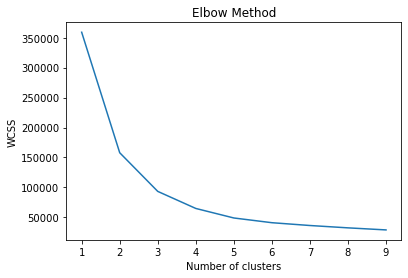

In [131]:
from sklearn.cluster import KMeans

Kmax = 10

X = np.array(X)
X_train = X.reshape(-1,3)

wcss = []
for i in range(1, Kmax):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, Kmax), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [132]:

K=5

# Train the K-means classifier
kmeans = KMeans(n_clusters=K, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_train)

# Store the 
percent_classes_array = []


for k in range(0,len(X)):
    X_test = X[k]
    pred_y = kmeans.predict(X_test.reshape(-1,3))
    pred_y = pred_y.reshape(X_test.shape[0],X_test.shape[1])
    percent_classes_array.append(count_pixels_per_class_X(pred_y,K=4))
        
percent_classes_array = np.array(percent_classes_array)

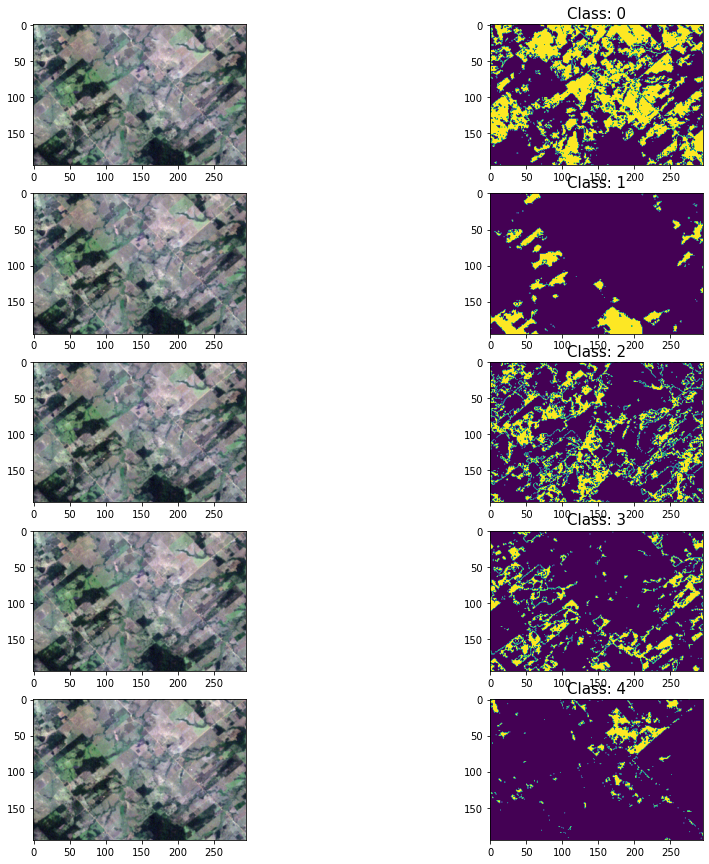

In [144]:
X_test = X[3]
pred_y = kmeans.predict(X_test.reshape(-1,3))
pred_y = pred_y.reshape(X_test.shape[0],X_test.shape[1]) 

f, axarr = plt.subplots(K,2)
f.set_figheight(15)
f.set_figwidth(15)

for k in range(K):
    axarr[k,0].imshow(X_test)
    axarr[k,1].set_title('Class: '+str(k),size=15)
    
    axarr[k,1].imshow(pred_y==k)

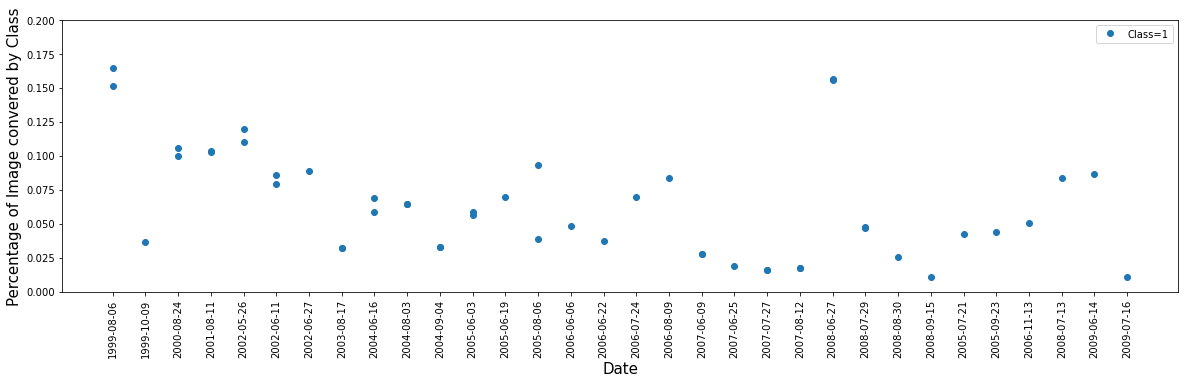

In [182]:
# Choose the class to focus on
k=1



time_raw = np.array([date.split('T')[0] for date in ts_dates])
yt_raw = percent_classes_array[:,k].flatten()

# Filter the data according to a threshold value
time = time_raw[(yt_raw<=0.2)]
yt = yt_raw[(yt_raw<=0.2)]

plt.figure(figsize=(20,5))
plt.plot(time,yt,'o',label='Class='+str(k))
plt.ylabel('Percentage of Image convered by Class',size=15)
plt.xlabel('Date',size=15)
plt.ylim(0.0,0.2)
plt.xticks(rotation='90')
plt.legend()
plt.show()